# <center> 👉 class_13_5 » _OpenPose vs MediaPipe_ </center>

## ▣ OpenPose for Multi and MediaPipe for Singular 

In [1]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## ▶ Specify the model to be used  

COCO and MPI are body pose estimation model.   
- COCO has 18 points and 
- MPI has 15 points as output.

HAND is hand keypoints estimation model.   
- It has 22 points as output

Ensure that the model files are available in the folders.

In [2]:
MODE = "MPI"

if MODE is "COCO":
    protoFile = "./pose_est/coco/coco_pose_deploy_linevec.prototxt"
    weightsFile = "./pose_est/coco_pose_iter_440000.caffemodel"
    nPoints = 18
    POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13],[0,14],[0,15],[14,16],[15,17]]

elif MODE is "MPI" :
    protoFile = "./pose_est/mpi/mpi_pose_deploy_linevec_faster_4_stages.prototxt"
    weightsFile = "./pose_est/mpi_pose_iter_160000.caffemodel"
    nPoints = 15
    POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10], [14,11], [11,12], [12,13] ]
    

Next, load an image with multiple people and check what the model sees

In [11]:
image1 = cv2.imread("./images/CV/people6.webp")
frameWidth = image1.shape[1]
frameHeight = image1.shape[0]
threshold = 0.1

plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.show()

Load the network and pass the image through the network

In [12]:
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

inWidth = 368
inHeight = 368
inpBlob = cv2.dnn.blobFromImage(image1, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)
output = net.forward()
H = output.shape[2]
W = output.shape[3]
print(output.shape)

(1, 44, 46, 46)


Slice a probability map from the output for a specific keypoint and plot the heatmap (after resizing) on the image itself

In [13]:
i = 5
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.imshow(probMap, alpha=0.6)
plt.colorbar()
plt.axis("off")

(-0.5, 520.5, 332.5, -0.5)

Similarly plot the affinity map on the image

(-0.5, 520.5, 332.5, -0.5)

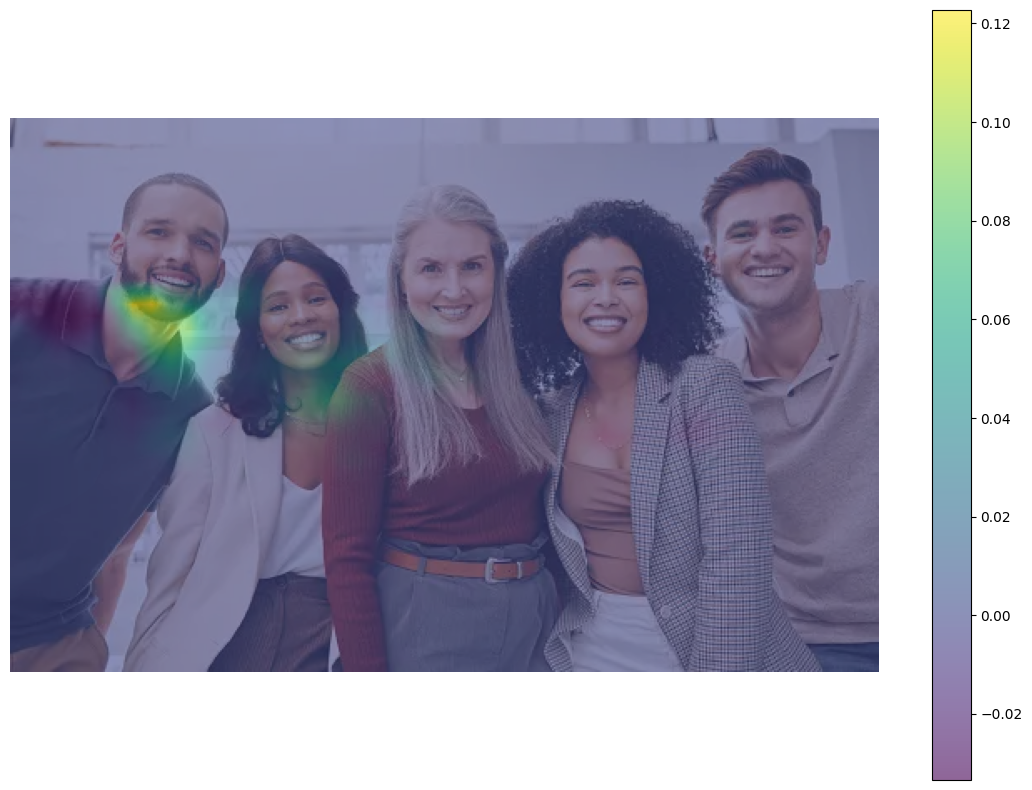

In [14]:
i = 24
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.imshow(probMap, alpha=0.6)
plt.colorbar()
plt.axis("off")

### Next, we find the keypoints for a image with only single person

In [ ]:
frame = cv2.imread("./images/CV/single.jpeg")
frameCopy = np.copy(frame)
frameWidth = frame.shape[1]
frameHeight = frame.shape[0]
threshold = 0.1

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.show()

In [ ]:
# Pass it through the network

inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)
net.setInput(inpBlob)
output = net.forward()
H = output.shape[2]
W = output.shape[3]

gather the points and plot the keypoints and the skeleton figure

# Empty list to store the detected keypoints
points = []

for i in range(nPoints):
    # confidence map of corresponding body's part.
    probMap = output[0, i, :, :]

    # Find global maxima of the probMap.
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
    
    # Scale the point to fit on the original image
    x = (frameWidth * point[0]) / W
    y = (frameHeight * point[1]) / H

    if prob > threshold : 
        cv2.circle(frameCopy, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)
        cv2.circle(frame, (int(x), int(y)), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

        # Add the point to the list if the probability is greater than the threshold
        points.append((int(x), int(y)))
    else :
        points.append(None)

# Draw Skeleton
for pair in POSE_PAIRS:
    partA = pair[0]
    partB = pair[1]

    if points[partA] and points[partB]:
        cv2.line(frame, points[partA], points[partB], (0, 255, 255), 3)

plt.figure(figsize=[10,10])
plt.subplot(121),plt.imshow(cv2.cvtColor(frameCopy, cv2.COLOR_BGR2RGB)),plt.title('Detected_keypoints')
plt.subplot(122),plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)),plt.title('Connected_keypoints-Skeleton Figure')
plt.show()

## ▣ Real Time Video MediaPipe vs OpenPose w/ COCO vs MPI

In [21]:
# mp
import cv2
import mediapipe as mp
import time

mpPose = mp.solutions.pose
pose = mpPose.Pose()
mpDraw = mp.solutions.drawing_utils

#cap = cv2.VideoCapture(0)
cap = cv2.VideoCapture('./Videos/pose_sample_video.mp4')
# cap = cv2.VideoCapture('./Videos/people_walk.mp4')
pTime = 0

while True:
    success, img = cap.read()
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_org = imgRGB.copy()
    results = pose.process(imgRGB)
#     print(results.pose_landmarks)
    if results.pose_landmarks:
        mpDraw.draw_landmarks(img, results.pose_landmarks, mpPose.POSE_CONNECTIONS)
        for id, lm in enumerate(results.pose_landmarks.landmark):
            h, w,c = img.shape
            print(id, lm)
            cx, cy = int(lm.x*w), int(lm.y*h)
            cv2.circle(img, (cx, cy), 5, (255,0,0), cv2.FILLED)

        cTime = time.time()
        fps = 1/(cTime-pTime)
        pTime = cTime

    cv2.putText(img, str(int(fps)), (50,50), cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0), 3)
    cv2.imshow("Org", img_org)
    cv2.imshow("Image", img)
    if cv2.waitKey(10) & 0xFF == 27:
        break
cap.release()
cv2.destroyAllWindows()

0 x: 0.47922399640083313
y: 0.2386193871498108
z: -0.35171547532081604
visibility: 0.9999929666519165

1 x: 0.49101802706718445
y: 0.22797709703445435
z: -0.3339546322822571
visibility: 0.9999912977218628

2 x: 0.4984978437423706
y: 0.22744210064411163
z: -0.33397945761680603
visibility: 0.9999914169311523

3 x: 0.5059518814086914
y: 0.2267724573612213
z: -0.33405718207359314
visibility: 0.9999918937683105

4 x: 0.47549253702163696
y: 0.22959627211093903
z: -0.31535476446151733
visibility: 0.9999815225601196

5 x: 0.47157716751098633
y: 0.23029544949531555
z: -0.3152647316455841
visibility: 0.9999717473983765

6 x: 0.46816369891166687
y: 0.2310429960489273
z: -0.315268337726593
visibility: 0.999964714050293

7 x: 0.5262469053268433
y: 0.23683634400367737
z: -0.16986966133117676
visibility: 0.999984622001648

8 x: 0.479571670293808
y: 0.24147742986679077
z: -0.08814161270856857
visibility: 0.9999760389328003

9 x: 0.4969503581523895
y: 0.24954292178153992
z: -0.2882494628429413
visibili

0 x: 0.47080475091934204
y: 0.25364571809768677
z: -0.4065534770488739
visibility: 0.9999751448631287

1 x: 0.4856972098350525
y: 0.24230802059173584
z: -0.40460464358329773
visibility: 0.9999422430992126

2 x: 0.49111616611480713
y: 0.24203020334243774
z: -0.4045248329639435
visibility: 0.9999421238899231

3 x: 0.4964638352394104
y: 0.24181202054023743
z: -0.4044744670391083
visibility: 0.9999340772628784

4 x: 0.4776073694229126
y: 0.24366635084152222
z: -0.3790336549282074
visibility: 0.9999393820762634

5 x: 0.47689586877822876
y: 0.24418233335018158
z: -0.37918150424957275
visibility: 0.9999433755874634

6 x: 0.47596973180770874
y: 0.24462634325027466
z: -0.3791750967502594
visibility: 0.9999358654022217

7 x: 0.5217530727386475
y: 0.25340133905410767
z: -0.33050665259361267
visibility: 0.9998899102210999

8 x: 0.4905875027179718
y: 0.25597941875457764
z: -0.21683453023433685
visibility: 0.9998688101768494

9 x: 0.4842018485069275
y: 0.265376478433609
z: -0.3773828446865082
visibi

0 x: 0.48387494683265686
y: 0.24535822868347168
z: -0.4570741653442383
visibility: 0.9999783039093018

1 x: 0.49720361828804016
y: 0.23652046918869019
z: -0.43982571363449097
visibility: 0.9999440312385559

2 x: 0.5031661987304688
y: 0.23641341924667358
z: -0.439865380525589
visibility: 0.9999450445175171

3 x: 0.5097482204437256
y: 0.23639263212680817
z: -0.43986910581588745
visibility: 0.9999362230300903

4 x: 0.4875909984111786
y: 0.23781655728816986
z: -0.41497042775154114
visibility: 0.9999446272850037

5 x: 0.48537465929985046
y: 0.23844310641288757
z: -0.4150926470756531
visibility: 0.9999505281448364

6 x: 0.4833175837993622
y: 0.23914596438407898
z: -0.4150547683238983
visibility: 0.9999443292617798

7 x: 0.534354031085968
y: 0.24909768998622894
z: -0.3214821517467499
visibility: 0.9999030828475952

8 x: 0.4977990686893463
y: 0.2520323097705841
z: -0.25433316826820374
visibility: 0.9998788237571716

9 x: 0.49283483624458313
y: 0.2605768144130707
z: -0.411967933177948
visibilit

0 x: 0.5267001390457153
y: 0.23564410209655762
z: -0.4496230483055115
visibility: 0.999980628490448

1 x: 0.5405219197273254
y: 0.2271489053964615
z: -0.42310404777526855
visibility: 0.9999455213546753

2 x: 0.5478434562683105
y: 0.22756710648536682
z: -0.4230947196483612
visibility: 0.9999468922615051

3 x: 0.553838312625885
y: 0.22802473604679108
z: -0.4230955243110657
visibility: 0.9999431371688843

4 x: 0.5188789367675781
y: 0.22758649289608002
z: -0.4035574793815613
visibility: 0.9999439120292664

5 x: 0.5124967098236084
y: 0.2284693419933319
z: -0.40360167622566223
visibility: 0.9999473690986633

6 x: 0.5060892105102539
y: 0.229534313082695
z: -0.4035312533378601
visibility: 0.9999416470527649

7 x: 0.56586754322052
y: 0.23805738985538483
z: -0.20641466975212097
visibility: 0.999919593334198

8 x: 0.5032558441162109
y: 0.24124546349048615
z: -0.17528191208839417
visibility: 0.9998583793640137

9 x: 0.5416615009307861
y: 0.25375232100486755
z: -0.3935052454471588
visibility: 0.999

0 x: 0.5542768836021423
y: 0.23308196663856506
z: -0.29346638917922974
visibility: 0.9999857544898987

1 x: 0.5635257363319397
y: 0.22463804483413696
z: -0.2527855634689331
visibility: 0.9999598264694214

2 x: 0.5696775913238525
y: 0.22522322833538055
z: -0.2527977526187897
visibility: 0.9999608397483826

3 x: 0.5752406120300293
y: 0.2256908416748047
z: -0.25281891226768494
visibility: 0.9999580979347229

4 x: 0.5445245504379272
y: 0.22432109713554382
z: -0.2510864734649658
visibility: 0.9999587535858154

5 x: 0.5370949506759644
y: 0.22493372857570648
z: -0.2511066198348999
visibility: 0.9999611973762512

6 x: 0.5298274159431458
y: 0.22594602406024933
z: -0.25102466344833374
visibility: 0.9999570846557617

7 x: 0.5840904116630554
y: 0.23515956103801727
z: -0.05259513482451439
visibility: 0.9999407529830933

8 x: 0.5182703733444214
y: 0.23728249967098236
z: -0.047265663743019104
visibility: 0.9998961687088013

9 x: 0.5652819871902466
y: 0.25107988715171814
z: -0.22324016690254211
visibi

0 x: 0.5662632584571838
y: 0.23401851952075958
z: -0.3808317184448242
visibility: 0.9999897480010986

1 x: 0.575392484664917
y: 0.22543145716190338
z: -0.3394361734390259
visibility: 0.9999709725379944

2 x: 0.5819990038871765
y: 0.22598813474178314
z: -0.33937907218933105
visibility: 0.9999716877937317

3 x: 0.5888686776161194
y: 0.22650682926177979
z: -0.33941805362701416
visibility: 0.9999698400497437

4 x: 0.5565939545631409
y: 0.22537632286548615
z: -0.3418835699558258
visibility: 0.9999696016311646

5 x: 0.5494673252105713
y: 0.22606150805950165
z: -0.3417470455169678
visibility: 0.9999704360961914

6 x: 0.5419232845306396
y: 0.22697027027606964
z: -0.34179699420928955
visibility: 0.9999678134918213

7 x: 0.599041759967804
y: 0.23769241571426392
z: -0.1251477599143982
visibility: 0.9999546408653259

8 x: 0.5315119028091431
y: 0.23865056037902832
z: -0.14524373412132263
visibility: 0.9999288320541382

9 x: 0.5786176323890686
y: 0.25124385952949524
z: -0.2989104092121124
visibility

0 x: 0.5712919235229492
y: 0.23996135592460632
z: -0.2422487437725067
visibility: 0.9999910593032837

1 x: 0.5792624354362488
y: 0.23066163063049316
z: -0.19999486207962036
visibility: 0.9999783635139465

2 x: 0.585425078868866
y: 0.23073869943618774
z: -0.2000129520893097
visibility: 0.9999785423278809

3 x: 0.591133713722229
y: 0.23070424795150757
z: -0.2001451551914215
visibility: 0.9999776482582092

4 x: 0.5600643157958984
y: 0.2317405641078949
z: -0.20236742496490479
visibility: 0.9999755024909973

5 x: 0.5522873997688293
y: 0.2326757162809372
z: -0.20232492685317993
visibility: 0.9999738335609436

6 x: 0.5438787341117859
y: 0.23366646468639374
z: -0.20223075151443481
visibility: 0.9999719858169556

7 x: 0.5999224185943604
y: 0.24058131873607635
z: 0.015716811642050743
visibility: 0.9999658465385437

8 x: 0.5334644913673401
y: 0.24574922025203705
z: 0.000283835077425465
visibility: 0.9999476671218872

9 x: 0.5837848782539368
y: 0.2560540735721588
z: -0.1652434766292572
visibility:

0 x: 0.5820652842521667
y: 0.24414995312690735
z: -0.5469009876251221
visibility: 0.9999895095825195

1 x: 0.5874324440956116
y: 0.23366647958755493
z: -0.5036752223968506
visibility: 0.9999778270721436

2 x: 0.5929330587387085
y: 0.2337706834077835
z: -0.5037089586257935
visibility: 0.9999770522117615

3 x: 0.5972424149513245
y: 0.23382523655891418
z: -0.503762423992157
visibility: 0.9999762773513794

4 x: 0.5677109360694885
y: 0.23503375053405762
z: -0.5024582743644714
visibility: 0.9999731183052063

5 x: 0.5597068071365356
y: 0.23665228486061096
z: -0.5025294423103333
visibility: 0.9999713897705078

6 x: 0.5529935359954834
y: 0.23807597160339355
z: -0.5024266839027405
visibility: 0.9999684691429138

7 x: 0.6045576930046082
y: 0.24338385462760925
z: -0.28182268142700195
visibility: 0.9999674558639526

8 x: 0.5427986979484558
y: 0.2501485049724579
z: -0.2746331989765167
visibility: 0.9999293684959412

9 x: 0.5947626233100891
y: 0.26135680079460144
z: -0.46776193380355835
visibility: 0

0 x: 0.6220198273658752
y: 0.24176159501075745
z: -0.5509771704673767
visibility: 0.999991774559021

1 x: 0.6218454837799072
y: 0.23164337873458862
z: -0.5095647573471069
visibility: 0.9999812841415405

2 x: 0.6252639293670654
y: 0.23174001276493073
z: -0.5096513628959656
visibility: 0.9999812841415405

3 x: 0.6286299228668213
y: 0.23182612657546997
z: -0.509743332862854
visibility: 0.999980628490448

4 x: 0.607817530632019
y: 0.23227104544639587
z: -0.5157843232154846
visibility: 0.9999768733978271

5 x: 0.6010739803314209
y: 0.2330496907234192
z: -0.5158481597900391
visibility: 0.9999765753746033

6 x: 0.5937764644622803
y: 0.23366808891296387
z: -0.5157329440116882
visibility: 0.999973714351654

7 x: 0.6235855221748352
y: 0.24125657975673676
z: -0.28849923610687256
visibility: 0.9999762177467346

8 x: 0.5747508406639099
y: 0.24717409908771515
z: -0.3109174370765686
visibility: 0.9999414682388306

9 x: 0.6284653544425964
y: 0.2577967941761017
z: -0.4697939157485962
visibility: 0.9999

0 x: 0.6399741172790527
y: 0.24590076506137848
z: -0.4046855568885803
visibility: 0.9999891519546509

1 x: 0.6371380090713501
y: 0.23550260066986084
z: -0.3634997010231018
visibility: 0.9999578595161438

2 x: 0.6394211053848267
y: 0.23593179881572723
z: -0.36358726024627686
visibility: 0.9999597072601318

3 x: 0.6413273811340332
y: 0.23632492125034332
z: -0.36367249488830566
visibility: 0.9999581575393677

4 x: 0.625167965888977
y: 0.2351159155368805
z: -0.37559282779693604
visibility: 0.999959409236908

5 x: 0.6188215613365173
y: 0.2351858913898468
z: -0.3755938708782196
visibility: 0.9999638795852661

6 x: 0.6112947463989258
y: 0.23511569201946259
z: -0.3755077123641968
visibility: 0.9999629855155945

7 x: 0.6310200691223145
y: 0.2450834959745407
z: -0.14761418104171753
visibility: 0.9999537467956543

8 x: 0.5907261371612549
y: 0.24718976020812988
z: -0.19527041912078857
visibility: 0.99992835521698

9 x: 0.6431025266647339
y: 0.26167887449264526
z: -0.32448700070381165
visibility: 0

0 x: 0.6262825131416321
y: 0.24301889538764954
z: -0.26805245876312256
visibility: 0.9999921321868896

1 x: 0.6279031038284302
y: 0.23335601389408112
z: -0.23644202947616577
visibility: 0.9999698400497437

2 x: 0.631894588470459
y: 0.23384444415569305
z: -0.23642629384994507
visibility: 0.9999711513519287

3 x: 0.6353775262832642
y: 0.23427662253379822
z: -0.23649586737155914
visibility: 0.999970018863678

4 x: 0.6130955815315247
y: 0.23326170444488525
z: -0.24985496699810028
visibility: 0.9999715089797974

5 x: 0.6059256792068481
y: 0.23350656032562256
z: -0.2497735619544983
visibility: 0.9999744892120361

6 x: 0.5980560779571533
y: 0.23373110592365265
z: -0.24969090521335602
visibility: 0.9999738931655884

7 x: 0.629192590713501
y: 0.24408213794231415
z: -0.06998703628778458
visibility: 0.9999666810035706

8 x: 0.5792767405509949
y: 0.24517349898815155
z: -0.1298484355211258
visibility: 0.9999515414237976

9 x: 0.6335375905036926
y: 0.25814124941825867
z: -0.20590665936470032
visibil

0 x: 0.5769684910774231
y: 0.2344127893447876
z: -0.3925692141056061
visibility: 0.9999935030937195

1 x: 0.5833876132965088
y: 0.2256367802619934
z: -0.36428576707839966
visibility: 0.9999775290489197

2 x: 0.5897074341773987
y: 0.2255571186542511
z: -0.36427998542785645
visibility: 0.999978244304657

3 x: 0.5945530533790588
y: 0.2255164235830307
z: -0.3643834590911865
visibility: 0.9999775290489197

4 x: 0.5638568997383118
y: 0.22690947353839874
z: -0.3659081757068634
visibility: 0.9999777674674988

5 x: 0.556908905506134
y: 0.22784514725208282
z: -0.36581557989120483
visibility: 0.9999776482582092

6 x: 0.5498195886611938
y: 0.22895531356334686
z: -0.36582502722740173
visibility: 0.9999768733978271

7 x: 0.6027591228485107
y: 0.2346881926059723
z: -0.1877543032169342
visibility: 0.9999737739562988

8 x: 0.5415471792221069
y: 0.240894615650177
z: -0.20573657751083374
visibility: 0.999963104724884

9 x: 0.5920469164848328
y: 0.24978049099445343
z: -0.32687002420425415
visibility: 0.99

0 x: 0.5493601560592651
y: 0.2331201136112213
z: -0.46407949924468994
visibility: 0.9999915957450867

1 x: 0.557229220867157
y: 0.2234407216310501
z: -0.4230651557445526
visibility: 0.9999783039093018

2 x: 0.5644795298576355
y: 0.22327323257923126
z: -0.4230653941631317
visibility: 0.999977707862854

3 x: 0.570909857749939
y: 0.2232634276151657
z: -0.42316320538520813
visibility: 0.999976634979248

4 x: 0.5367521047592163
y: 0.22510719299316406
z: -0.4299999475479126
visibility: 0.999976634979248

5 x: 0.5311429500579834
y: 0.22606965899467468
z: -0.4300278425216675
visibility: 0.9999741315841675

6 x: 0.5240418910980225
y: 0.22722280025482178
z: -0.43005436658859253
visibility: 0.9999726414680481

7 x: 0.5799980163574219
y: 0.2310342788696289
z: -0.18440143764019012
visibility: 0.9999746680259705

8 x: 0.5167760848999023
y: 0.23893530666828156
z: -0.21875131130218506
visibility: 0.9999600052833557

9 x: 0.5655060410499573
y: 0.24907976388931274
z: -0.3748339116573334
visibility: 0.99

0 x: 0.5308385491371155
y: 0.23288200795650482
z: -0.5819411277770996
visibility: 0.9999881386756897

1 x: 0.5391008853912354
y: 0.2227783203125
z: -0.5431212186813354
visibility: 0.9999688267707825

2 x: 0.5460172891616821
y: 0.22266504168510437
z: -0.5431576371192932
visibility: 0.9999687075614929

3 x: 0.5532044172286987
y: 0.22260761260986328
z: -0.5432112216949463
visibility: 0.9999666810035706

4 x: 0.5215745568275452
y: 0.22394175827503204
z: -0.5411562919616699
visibility: 0.9999635815620422

5 x: 0.5145120024681091
y: 0.22481206059455872
z: -0.5412623286247253
visibility: 0.999965488910675

6 x: 0.5085112452507019
y: 0.22563588619232178
z: -0.5412108898162842
visibility: 0.999962568283081

7 x: 0.5634024143218994
y: 0.22987054288387299
z: -0.3338225483894348
visibility: 0.9999614357948303

8 x: 0.5001160502433777
y: 0.23748913407325745
z: -0.32502493262290955
visibility: 0.9999058842658997

9 x: 0.5443563461303711
y: 0.24889780580997467
z: -0.5064088702201843
visibility: 0.999

0 x: 0.5216963291168213
y: 0.232888326048851
z: -0.5484058260917664
visibility: 0.9999857544898987

1 x: 0.530778169631958
y: 0.22222010791301727
z: -0.506121814250946
visibility: 0.9999573826789856

2 x: 0.5379960536956787
y: 0.22206859290599823
z: -0.5062093138694763
visibility: 0.9999597668647766

3 x: 0.5450650453567505
y: 0.22201211750507355
z: -0.506334125995636
visibility: 0.9999590516090393

4 x: 0.5119534730911255
y: 0.22337505221366882
z: -0.516255795955658
visibility: 0.9999435544013977

5 x: 0.5054180026054382
y: 0.22418655455112457
z: -0.5164786577224731
visibility: 0.9999454617500305

6 x: 0.49787604808807373
y: 0.22526022791862488
z: -0.5163668990135193
visibility: 0.999937891960144

7 x: 0.5547077655792236
y: 0.22914187610149384
z: -0.28654804825782776
visibility: 0.9999507069587708

8 x: 0.49021562933921814
y: 0.23739959299564362
z: -0.2796844244003296
visibility: 0.9998367428779602

9 x: 0.5366825461387634
y: 0.24878159165382385
z: -0.4650963246822357
visibility: 0.99

0 x: 0.5161239504814148
y: 0.2596742808818817
z: -0.38495898246765137
visibility: 0.9999877214431763

1 x: 0.5247992277145386
y: 0.24837209284305573
z: -0.34353047609329224
visibility: 0.9999617338180542

2 x: 0.5310796499252319
y: 0.24856442213058472
z: -0.3435799181461334
visibility: 0.9999650120735168

3 x: 0.5376050472259521
y: 0.24846959114074707
z: -0.3435889780521393
visibility: 0.9999637603759766

4 x: 0.5058305859565735
y: 0.2490503340959549
z: -0.3434353172779083
visibility: 0.9999485015869141

5 x: 0.49996206164360046
y: 0.25000515580177307
z: -0.3433876633644104
visibility: 0.9999489784240723

6 x: 0.4951898753643036
y: 0.25073984265327454
z: -0.34343165159225464
visibility: 0.9999411702156067

7 x: 0.5478559136390686
y: 0.2587178945541382
z: -0.13454873859882355
visibility: 0.9999514222145081

8 x: 0.4861358404159546
y: 0.26277461647987366
z: -0.13549382984638214
visibility: 0.9998648166656494

9 x: 0.530491828918457
y: 0.2746258080005646
z: -0.3103450536727905
visibility:

0 x: 0.5105171799659729
y: 0.27280333638191223
z: -0.4515884816646576
visibility: 0.9999914765357971

1 x: 0.520356297492981
y: 0.26148441433906555
z: -0.40510231256484985
visibility: 0.999974250793457

2 x: 0.5275304317474365
y: 0.26144811511039734
z: -0.40511354804039
visibility: 0.9999763369560242

3 x: 0.5342837572097778
y: 0.26150432229042053
z: -0.4051022231578827
visibility: 0.9999754428863525

4 x: 0.49942636489868164
y: 0.2626253664493561
z: -0.4038357436656952
visibility: 0.9999649524688721

5 x: 0.49177563190460205
y: 0.26365959644317627
z: -0.40393245220184326
visibility: 0.9999650716781616

6 x: 0.4866589903831482
y: 0.26452353596687317
z: -0.4038962423801422
visibility: 0.9999598860740662

7 x: 0.5412824153900146
y: 0.2714509665966034
z: -0.16263940930366516
visibility: 0.999967098236084

8 x: 0.4781772196292877
y: 0.2757953107357025
z: -0.15660858154296875
visibility: 0.9999077320098877

9 x: 0.5247995853424072
y: 0.2894889712333679
z: -0.364803284406662
visibility: 0.99

0 x: 0.5084257125854492
y: 0.2713637053966522
z: -0.2279166430234909
visibility: 0.9999915957450867

1 x: 0.5172533392906189
y: 0.25998419523239136
z: -0.18268343806266785
visibility: 0.9999784827232361

2 x: 0.5239771604537964
y: 0.25957661867141724
z: -0.18264198303222656
visibility: 0.9999797344207764

3 x: 0.530256986618042
y: 0.25934839248657227
z: -0.18268439173698425
visibility: 0.9999796152114868

4 x: 0.49744829535484314
y: 0.261233389377594
z: -0.18289382755756378
visibility: 0.999967634677887

5 x: 0.49026548862457275
y: 0.26221972703933716
z: -0.18297836184501648
visibility: 0.999967634677887

6 x: 0.4837474822998047
y: 0.2629960775375366
z: -0.18293970823287964
visibility: 0.9999644160270691

7 x: 0.5375287532806396
y: 0.2673881947994232
z: 0.024425532668828964
visibility: 0.9999741315841675

8 x: 0.4751097857952118
y: 0.2733652889728546
z: 0.020963938906788826
visibility: 0.9999042749404907

9 x: 0.5226228833198547
y: 0.28750213980674744
z: -0.15496592223644257
visibility

0 x: 0.5069077014923096
y: 0.22931210696697235
z: -0.152500718832016
visibility: 0.9999646544456482

1 x: 0.5154526829719543
y: 0.21912644803524017
z: -0.11360450834035873
visibility: 0.9999387264251709

2 x: 0.5221056342124939
y: 0.21920770406723022
z: -0.11364187300205231
visibility: 0.9999386668205261

3 x: 0.5283362865447998
y: 0.21926528215408325
z: -0.11378970742225647
visibility: 0.9999539256095886

4 x: 0.4962838888168335
y: 0.22074659168720245
z: -0.11745166778564453
visibility: 0.9999222159385681

5 x: 0.48938480019569397
y: 0.2218426764011383
z: -0.11748029291629791
visibility: 0.999916672706604

6 x: 0.48259857296943665
y: 0.22286875545978546
z: -0.1174168586730957
visibility: 0.999916136264801

7 x: 0.5372799634933472
y: 0.22886282205581665
z: 0.08452501147985458
visibility: 0.999951183795929

8 x: 0.4752040505409241
y: 0.2347015142440796
z: 0.06748957186937332
visibility: 0.9997784495353699

9 x: 0.5218569040298462
y: 0.24372410774230957
z: -0.07986366003751755
visibility

0 x: 0.5179591178894043
y: 0.18831299245357513
z: -0.05520729720592499
visibility: 0.999957263469696

1 x: 0.5262335538864136
y: 0.18358787894248962
z: -0.018797090277075768
visibility: 0.9999192953109741

2 x: 0.5322706699371338
y: 0.18435262143611908
z: -0.018821466714143753
visibility: 0.9999175071716309

3 x: 0.5381606221199036
y: 0.18512438237667084
z: -0.018887821584939957
visibility: 0.9999396204948425

4 x: 0.5098567605018616
y: 0.1844979226589203
z: -0.016818933188915253
visibility: 0.9999164342880249

5 x: 0.5044863820075989
y: 0.18595664203166962
z: -0.01678718999028206
visibility: 0.9999067187309265

6 x: 0.499315470457077
y: 0.18742580711841583
z: -0.016701050102710724
visibility: 0.9999139904975891

7 x: 0.5540664792060852
y: 0.19922973215579987
z: 0.13624820113182068
visibility: 0.9999186396598816

8 x: 0.4947483241558075
y: 0.2043057382106781
z: 0.14775538444519043
visibility: 0.9997822642326355

9 x: 0.5335638523101807
y: 0.20407411456108093
z: -0.0020406669937074184
v

0 x: 0.5356886386871338
y: 0.1967003494501114
z: -0.5631865859031677
visibility: 0.9999695420265198

1 x: 0.5457295179367065
y: 0.18721464276313782
z: -0.5271468758583069
visibility: 0.9999366998672485

2 x: 0.5519137978553772
y: 0.1874466985464096
z: -0.527215838432312
visibility: 0.9999363422393799

3 x: 0.559468686580658
y: 0.18773727118968964
z: -0.5273114442825317
visibility: 0.9999512434005737

4 x: 0.5270484685897827
y: 0.18935146927833557
z: -0.5277441143989563
visibility: 0.9999367594718933

5 x: 0.5209811925888062
y: 0.1909208744764328
z: -0.5277881026268005
visibility: 0.9999305605888367

6 x: 0.5137839913368225
y: 0.192750483751297
z: -0.5277248024940491
visibility: 0.9999354481697083

7 x: 0.5776229500770569
y: 0.20081526041030884
z: -0.3086789846420288
visibility: 0.9999295473098755

8 x: 0.5084220767021179
y: 0.2078043669462204
z: -0.30726635456085205
visibility: 0.9998438954353333

9 x: 0.5519839525222778
y: 0.21271681785583496
z: -0.4815913438796997
visibility: 0.99995

0 x: 0.5452182292938232
y: 0.20317158102989197
z: -0.7287963032722473
visibility: 0.999975860118866

1 x: 0.5579022765159607
y: 0.19430463016033173
z: -0.6932878494262695
visibility: 0.9999464154243469

2 x: 0.5638729333877563
y: 0.1942964494228363
z: -0.6932204365730286
visibility: 0.9999463558197021

3 x: 0.5712954998016357
y: 0.1945028305053711
z: -0.6933209896087646
visibility: 0.9999580383300781

4 x: 0.5376855134963989
y: 0.1956908404827118
z: -0.6893166899681091
visibility: 0.9999473690986633

5 x: 0.5304442644119263
y: 0.19669567048549652
z: -0.6894172430038452
visibility: 0.9999432563781738

6 x: 0.5223917365074158
y: 0.19781839847564697
z: -0.6893545985221863
visibility: 0.9999468922615051

7 x: 0.5876339077949524
y: 0.20488910377025604
z: -0.4730512797832489
visibility: 0.9999369382858276

8 x: 0.517224907875061
y: 0.21091477572917938
z: -0.4553440511226654
visibility: 0.9998721480369568

9 x: 0.5620482563972473
y: 0.21899473667144775
z: -0.6471134424209595
visibility: 0.999

In [20]:
# OpenPose
import cv2
import time
import numpy as np

MODE = "MPI"
# MODE = "COCO"

if MODE is "COCO":
    protoFile = "./pose_est/coco/coco_pose_deploy_linevec.prototxt"
    weightsFile = "./pose_est/coco_pose_iter_440000.caffemodel"
    nPoints = 18
    POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13],[0,14],[0,15],[14,16],[15,17]]

elif MODE is "MPI" :
    protoFile = "./pose_est/mpi/mpi_pose_deploy_linevec_faster_4_stages.prototxt"
    weightsFile = "./pose_est/mpi_pose_iter_160000.caffemodel"
    nPoints = 15
    POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10], [14,11], [11,12], [12,13] ]

inWidth = 368
inHeight = 368
threshold = 0.1
device = "cpu"

cap = cv2.VideoCapture('./Videos/pose_sample_video.mp4')
# cap = cv2.VideoCapture('./Videos/people_walk.mp4')
# video_fps = cap.get(cv2.CAP_PROP_FPS ) 
# delay = int(1000/video_fps)

hasFrame, frame = cap.read()
# vid_writer = cv2.VideoWriter('./results/pose_output.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame.shape[1],frame.shape[0]))
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)
if device == "cpu":
    net.setPreferableBackend(cv2.dnn.DNN_TARGET_CPU)
    print("Using CPU device")
elif device == "gpu":
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
    print("Using GPU device")

while cv2.waitKey(1) < 0:
    t = time.time()
    hasFrame, frame = cap.read()
    frameCopy = np.copy(frame)
    if not hasFrame:
        cv2.waitKey()
        break

    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                              (0, 0, 0), swapRB=False, crop=False)
    net.setInput(inpBlob)
    output = net.forward()

    H = output.shape[2]
    W = output.shape[3]
    
    points = []
    for i in range(nPoints):
        probMap = output[0, i, :, :] # confidence map of corresponding body's part.
        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap) # Find global maxima of the probMap
        x = (frameWidth * point[0]) / W  # Scale the point to fit on the original image
        y = (frameHeight * point[1]) / H

        if prob > threshold : 
            cv2.circle(frameCopy, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
            cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)
            points.append((int(x), int(y))) # Add the point to the list if the probability is greater than the threshold
        else :
            points.append(None)
    
    for pair in POSE_PAIRS: # Draw Skeleton
        partA = pair[0]
        partB = pair[1]

        if points[partA] and points[partB]:
            cv2.line(frame, points[partA], points[partB], (0, 255, 255), 3, lineType=cv2.LINE_AA)
            cv2.circle(frame, points[partA], 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
            cv2.circle(frame, points[partB], 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

    cv2.putText(frame, "time taken = {:.2f} sec".format(time.time() - t), (50, 50), cv2.FONT_HERSHEY_COMPLEX, .8, (255, 50, 0), 2, lineType=cv2.LINE_AA)
    # cv2.putText(frame, "OpenPose using OpenCV", (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 50, 0), 2, lineType=cv2.LINE_AA)
    # cv2.imshow('Output-Keypoints', frameCopy)
    cv2.imshow('Output-Skeleton', frame)
#     vid_writer.write(frame)
#     key = cv2.waitKey(delay)
    if cv2.waitKey(1) & 0xFF == 27:
        break
vid_writer.release()
cv2.destroyAllWindows()

Using CPU device
